# **This notebook acts as the data preprocessor of MIMIC-III**

# **Now ICU stays as aggregation template with mostly time series data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

## Loading our aggregated data

In [2]:
client_1 = pd.read_csv('client_1_ICUSTAY_raw_hour.csv', low_memory=False)

In [3]:
client_1

,ICUSTAY_ID,SUBJECT_ID,INTIME,OUTTIME,DATETIMEEVENTS_CGID_mean_h0,DATETIMEEVENTS_CGID_mean_h1,DATETIMEEVENTS_CGID_mean_h2,DATETIMEEVENTS_CGID_mean_h3,DATETIMEEVENTS_CGID_mean_h4,DATETIMEEVENTS_CGID_mean_h5,...,PROCEDUREEVENTS_MV_VALUEUOM_mode_h17,PROCEDUREEVENTS_MV_VALUEUOM_mode_h18,PROCEDUREEVENTS_MV_VALUEUOM_mode_h19,PROCEDUREEVENTS_MV_VALUEUOM_mode_h20,PROCEDUREEVENTS_MV_VALUEUOM_mode_h21,PROCEDUREEVENTS_MV_VALUEUOM_mode_h22,PROCEDUREEVENTS_MV_VALUEUOM_mode_h23,GENDER,DOB,DOD
0,280836,268,2198-02-14 23:27:38,2198-02-18 05:26:11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,2132-02-21,2198-02-18
1,206613,269,2170-11-05 11:05:29,2170-11-08 17:46:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2130-09-30,NaN
2,220345,270,2128-06-24 15:05:20,2128-06-27 12:32:29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2048-05-26,NaN
3,249196,271,2120-08-07 23:12:42,2120-08-10 00:39:04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,2074-11-30,NaN
4,210407,272,2186-12-25 21:08:04,2186-12-27 12:01:13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2119-11-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,201233,94944,2104-04-15 10:18:16,2104-04-17 14:51:00,NaN,NaN,NaN,NaN,15285.0,15285.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2027-03-02,NaN
61528,283653,94950,2155-12-08 05:33:16,2155-12-10 17:24:58,17053.0,NaN,NaN,15858.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,1855-12-07,NaN
61529,241585,94953,2160-03-03 16:09:11,2160-03-04 14:22:33,19610.0,NaN,NaN,20074.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,2107-01-29,2162-01-05
61530,202802,94954,2183-03-25 09:53:10,2183-03-27 17:55:03,NaN,15114.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,2115-05-23,NaN


## Understadig the structure of the dataset

In [4]:
# Basic structural overview
num_rows, num_columns = client_1.shape
column_names = client_1.columns.tolist()
data_types = client_1.dtypes
sample_rows = client_1.head(10)

# Count unnamed columns
unnamed_columns = [col for col in column_names if "Unnamed" in col]

# Summary results
structure_summary = {
    "Number of rows": num_rows,
    "Number of columns": num_columns,
    "Unnamed columns": unnamed_columns,
    "Data types sample": data_types.head(10).to_dict()
}

structure_summary

{'Number of rows': 61532,
 'Number of columns': 7307,
 'Unnamed columns': [],
 'Data types sample': {'ICUSTAY_ID': dtype('int64'),
  'SUBJECT_ID': dtype('int64'),
  'INTIME': dtype('O'),
  'OUTTIME': dtype('O'),
  'DATETIMEEVENTS_CGID_mean_h0': dtype('float64'),
  'DATETIMEEVENTS_CGID_mean_h1': dtype('float64'),
  'DATETIMEEVENTS_CGID_mean_h2': dtype('float64'),
  'DATETIMEEVENTS_CGID_mean_h3': dtype('float64'),
  'DATETIMEEVENTS_CGID_mean_h4': dtype('float64'),
  'DATETIMEEVENTS_CGID_mean_h5': dtype('float64')}}

In [5]:
# Classify columns by data type categories
categorical_cols = []
numerical_cols = []
datetime_cols = []

for col in client_1.columns:
    dtype = client_1[col].dtype
    if dtype == 'object':
        # Check if the column looks like a date
        try:
            pd.to_datetime(client_1[col].dropna().iloc[0])
            datetime_cols.append(col)
        except Exception:
            categorical_cols.append(col)
    elif pd.api.types.is_numeric_dtype(dtype):
        numerical_cols.append(col)

# Summary of data types
type_summary = {
    "Categorical columns (sample)": categorical_cols[:10],
    "Numerical columns (sample)": numerical_cols[:10],
    "Datetime columns (sample)": datetime_cols[:10],
    "Count - categorical": len(categorical_cols),
    "Count - numerical": len(numerical_cols),
    "Count - datetime-like": len(datetime_cols)
}

type_summary

{'Categorical columns (sample)': ['DATETIMEEVENTS_STOPPED_mode_h0',
  'DATETIMEEVENTS_STOPPED_mode_h1',
  'DATETIMEEVENTS_STOPPED_mode_h2',
  'DATETIMEEVENTS_STOPPED_mode_h3',
  'DATETIMEEVENTS_STOPPED_mode_h4',
  'DATETIMEEVENTS_STOPPED_mode_h5',
  'DATETIMEEVENTS_STOPPED_mode_h6',
  'DATETIMEEVENTS_STOPPED_mode_h7',
  'DATETIMEEVENTS_STOPPED_mode_h8',
  'DATETIMEEVENTS_STOPPED_mode_h9'],
 'Numerical columns (sample)': ['ICUSTAY_ID',
  'SUBJECT_ID',
  'DATETIMEEVENTS_CGID_mean_h0',
  'DATETIMEEVENTS_CGID_mean_h1',
  'DATETIMEEVENTS_CGID_mean_h2',
  'DATETIMEEVENTS_CGID_mean_h3',
  'DATETIMEEVENTS_CGID_mean_h4',
  'DATETIMEEVENTS_CGID_mean_h5',
  'DATETIMEEVENTS_CGID_mean_h6',
  'DATETIMEEVENTS_CGID_mean_h7'],
 'Datetime columns (sample)': ['INTIME',
  'OUTTIME',
  'DATETIMEEVENTS_STORETIME_mode_h0',
  'DATETIMEEVENTS_STORETIME_mode_h1',
  'DATETIMEEVENTS_STORETIME_mode_h2',
  'DATETIMEEVENTS_STORETIME_mode_h3',
  'DATETIMEEVENTS_STORETIME_mode_h4',
  'DATETIMEEVENTS_STORETIME_mode_h5'

## Checking the number of missing values

In [6]:
missing_chunk = client_1.copy()

# Calculate missing value stats
missing_stats = (
    missing_chunk.isnull().sum()
    .to_frame(name='Missing_Count')
    .assign(Total=missing_chunk.shape[0])
    .assign(Missing_Percent=lambda x: (x['Missing_Count'] / x['Total']) * 100)
    .sort_values(by='Missing_Percent', ascending=False)
)

# Filter only columns with missing values
missing_stats_filtered = missing_stats[missing_stats['Missing_Count'] > 0]

missing_stats_filtered.shape[0] # Number of columns with missing values

7278

In [7]:
# Display top 20 columns with the highest percentage of missing values
top_missing = missing_stats_filtered.head(20).copy()
top_missing.reset_index(inplace=True)
top_missing.rename(columns={'index': 'Column Name'}, inplace=True)

top_missing

,Column Name,Missing_Count,Total,Missing_Percent
0,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h21,61518,61532,99.977248
1,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h15,61518,61532,99.977248
2,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h18,61517,61532,99.975622
3,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h13,61515,61532,99.972372
4,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h9,61514,61532,99.970747
5,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h12,61514,61532,99.970747
6,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h23,61512,61532,99.967497
7,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h10,61512,61532,99.967497
8,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h11,61511,61532,99.965871
9,PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h8,61510,61532,99.964246


In [8]:
missing_percent = client_1.isnull().mean().sort_values(ascending=False) * 100
missing_percent

PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h21    99.977248
PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h15    99.977248
PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h18    99.975622
PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h13    99.972372
PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h9     99.970747
                                                   ...    
ICUSTAYS_DBSOURCE_mode_h0                         0.000000
ICUSTAYS_FIRST_CAREUNIT_mode_h0                   0.000000
ICUSTAYS_LAST_CAREUNIT_mode_h0                    0.000000
SUBJECT_ID                                        0.000000
ICUSTAY_ID                                        0.000000
Length: 7307, dtype: float64

In [9]:
# Define a threshold for dropping columns based on missing percentage
drop_threshold = 95 # percent
columns_to_drop = missing_stats_filtered[missing_stats_filtered['Missing_Percent'] > drop_threshold].index.tolist()

# Separate remaining columns for potential imputation (not to be dropped)
columns_to_impute = missing_stats_filtered[
    (missing_stats_filtered['Missing_Percent'] <= drop_threshold)
].index.tolist()

# Show the first few columns that would be dropped and imputed
drop_and_impute_summary = {
    "Columns to drop (sample)": columns_to_drop[:10],
    "Drop count": len(columns_to_drop),
    "Columns to impute (sample)": columns_to_impute[:10],
    "Impute count": len(columns_to_impute)
}

drop_and_impute_summary

{'Columns to drop (sample)': ['PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h21',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h15',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h18',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h13',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h9',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h12',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h23',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h10',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h11',
  'PROCEDUREEVENTS_MV_COMMENTS_EDITEDBY_mode_h8'],
 'Drop count': 1415,
 'Columns to impute (sample)': ['PROCEDUREEVENTS_MV_CGID_count_h6',
  'PROCEDUREEVENTS_MV_LINKORDERID_count_h6',
  'PROCEDUREEVENTS_MV_VALUE_min_h6',
  'PROCEDUREEVENTS_MV_HADM_ID_mean_h6',
  'PROCEDUREEVENTS_MV_STORETIME_mode_h6',
  'PROCEDUREEVENTS_MV_ISOPENBAG_max_h6',
  'PROCEDUREEVENTS_MV_LINKORDERID_min_h6',
  'PROCEDUREEVENTS_MV_STATUSDESCRIPTION_mode_h6',
  'PROCEDUREEVENTS_MV_CGID_min_h6',
  'PROCEDUREEVENTS_MV_ORDERID_count_h6']

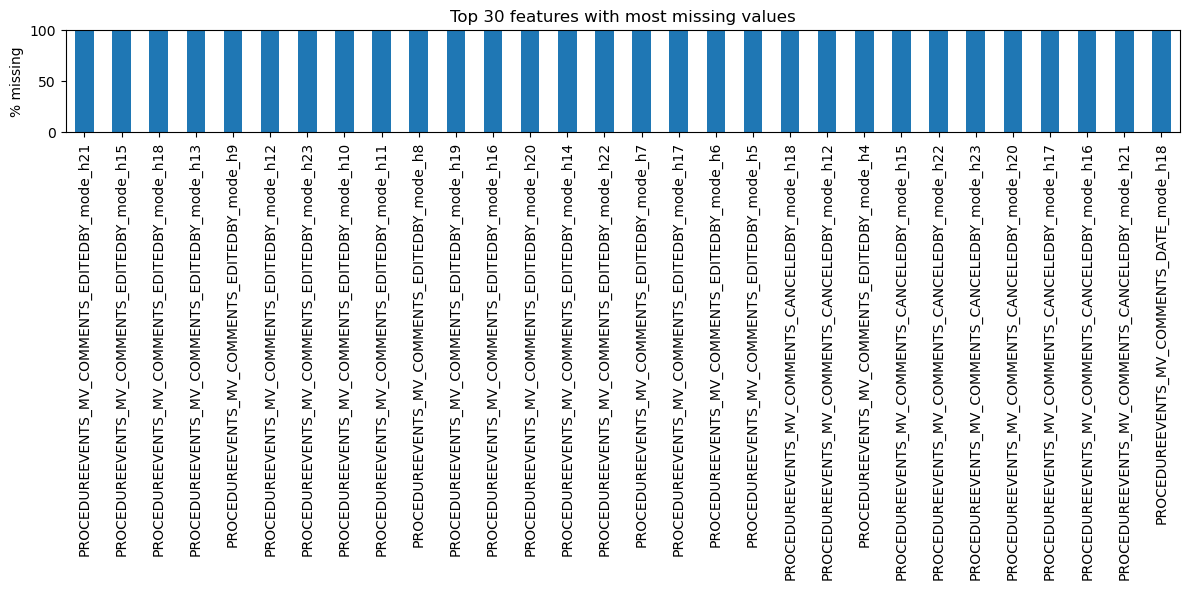

In [10]:
missing_percent.head(30).plot(kind='bar', figsize=(12, 6), title="Top 30 features with most missing values")
plt.ylabel('% missing')
plt.tight_layout()
plt.ylim(0,100)
plt.show()

In [13]:
client_1.drop(columns=columns_to_drop, inplace=True)

### Handling capital letters

In [14]:
client_1.columns = [col.lower() for col in client_1.columns] # Ensure lowercase
print(client_1.columns.tolist())

['icustay_id', 'subject_id', 'intime', 'outtime', 'datetimeevents_cgid_mean_h0', 'datetimeevents_cgid_mean_h1', 'datetimeevents_cgid_mean_h2', 'datetimeevents_cgid_mean_h3', 'datetimeevents_cgid_mean_h4', 'datetimeevents_cgid_mean_h5', 'datetimeevents_cgid_mean_h6', 'datetimeevents_cgid_mean_h7', 'datetimeevents_cgid_mean_h8', 'datetimeevents_cgid_mean_h9', 'datetimeevents_cgid_mean_h10', 'datetimeevents_cgid_mean_h11', 'datetimeevents_cgid_mean_h12', 'datetimeevents_cgid_mean_h13', 'datetimeevents_cgid_mean_h14', 'datetimeevents_cgid_mean_h15', 'datetimeevents_cgid_mean_h16', 'datetimeevents_cgid_mean_h17', 'datetimeevents_cgid_mean_h18', 'datetimeevents_cgid_mean_h19', 'datetimeevents_cgid_mean_h20', 'datetimeevents_cgid_mean_h21', 'datetimeevents_cgid_mean_h22', 'datetimeevents_cgid_mean_h23', 'datetimeevents_cgid_std_h0', 'datetimeevents_cgid_std_h1', 'datetimeevents_cgid_std_h2', 'datetimeevents_cgid_std_h3', 'datetimeevents_cgid_std_h4', 'datetimeevents_cgid_std_h5', 'datetimeeve

In [15]:
client_1

,icustay_id,subject_id,intime,outtime,datetimeevents_cgid_mean_h0,datetimeevents_cgid_mean_h1,datetimeevents_cgid_mean_h2,datetimeevents_cgid_mean_h3,datetimeevents_cgid_mean_h4,datetimeevents_cgid_mean_h5,...,procedureevents_mv_storetime_mode_h4,procedureevents_mv_storetime_mode_h5,procedureevents_mv_storetime_mode_h6,procedureevents_mv_valueuom_mode_h0,procedureevents_mv_valueuom_mode_h1,procedureevents_mv_valueuom_mode_h2,procedureevents_mv_valueuom_mode_h3,gender,dob,dod
0,280836,268,2198-02-14 23:27:38,2198-02-18 05:26:11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,2132-02-21,2198-02-18
1,206613,269,2170-11-05 11:05:29,2170-11-08 17:46:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2130-09-30,NaN
2,220345,270,2128-06-24 15:05:20,2128-06-27 12:32:29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2048-05-26,NaN
3,249196,271,2120-08-07 23:12:42,2120-08-10 00:39:04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,2074-11-30,NaN
4,210407,272,2186-12-25 21:08:04,2186-12-27 12:01:13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2119-11-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,201233,94944,2104-04-15 10:18:16,2104-04-17 14:51:00,NaN,NaN,NaN,NaN,15285.0,15285.0,...,2104-04-16 05:50:00,2104-04-17 14:35:00,NaN,NaN,NaN,NaN,NaN,M,2027-03-02,NaN
61528,283653,94950,2155-12-08 05:33:16,2155-12-10 17:24:58,17053.0,NaN,NaN,15858.0,NaN,NaN,...,NaN,2155-12-08 11:42:00,NaN,min,NaN,NaN,NaN,F,1855-12-07,NaN
61529,241585,94953,2160-03-03 16:09:11,2160-03-04 14:22:33,19610.0,NaN,NaN,20074.0,NaN,NaN,...,NaN,NaN,NaN,min,NaN,NaN,NaN,F,2107-01-29,2162-01-05
61530,202802,94954,2183-03-25 09:53:10,2183-03-27 17:55:03,NaN,15114.500000,NaN,NaN,NaN,NaN,...,2183-03-25 14:03:00,NaN,NaN,min,min,NaN,NaN,F,2115-05-23,NaN


### Like in MIMIC Extract handle cohorts

In [16]:
# First we try and compute patient age at the time of ICU admission.
client_1['dob'] = pd.to_datetime(client_1['dob'], errors='coerce')
client_1['intime'] = pd.to_datetime(client_1['intime'], errors='coerce')

years = client_1['intime'].dt.year - client_1['dob'].dt.year

had_birthday = ((client_1['intime'].dt.month > client_1['dob'].dt.month) | ((client_1['intime'].dt.month == client_1['dob'].dt.month) & (client_1['intime'].dt.day >= client_1['dob'].dt.day)))

client_1['age'] = years - (~had_birthday).astype(int)

client_1['age'] = client_1['age'].clip(lower=0, upper=89)
client_1.loc[client_1['dob'].isna() | client_1['intime'].isna() | (client_1['dob'] > client_1['intime']), 'age'] = pd.NA

In [17]:
adult = client_1[client_1['age'] >= 15].copy()

# We ensure only firs stay is kept, so no patient is counted twice
first_stays = adult.drop_duplicates(subset='subject_id', keep='first')

In [18]:
first_stays = first_stays.copy()

first_stays['intime']  = pd.to_datetime(first_stays['intime'])
first_stays['outtime'] = pd.to_datetime(first_stays['outtime'])

first_stays['los_hours'] = (
    first_stays['outtime'] - first_stays['intime']
).dt.total_seconds() / 3600

cohort = first_stays[
    (first_stays['los_hours'] >= 12) & # 12 hours
    (first_stays['los_hours'] < 240) # 10 days
]

In [19]:
# Generated code for summary check just to be sure:
print("All stays:", first_stays.shape[0])
print("Filtered cohort:", cohort.shape[0])
print(cohort['los_hours'].describe())

All stays: 38605
Filtered cohort: 34482
count    34482.000000
mean        63.281876
std         47.557268
min         12.000000
25%         28.009861
50%         47.515833
75%         79.298403
max        239.986944
Name: los_hours, dtype: float64


## Handling categorical variables

In [20]:
cohort = cohort.copy()

cohort['dod'] = pd.to_datetime(cohort['dod'])
cohort['is_alive'] = (cohort['dod'].isna() | (cohort['dod'] > cohort['outtime'])).astype(int)

In [21]:
# Also gender:
cohort['gender'] = cohort['gender'].map({'M':0,'F':1})

In [22]:
cohort.columns.tolist()

['icustay_id',
 'subject_id',
 'intime',
 'outtime',
 'datetimeevents_cgid_mean_h0',
 'datetimeevents_cgid_mean_h1',
 'datetimeevents_cgid_mean_h2',
 'datetimeevents_cgid_mean_h3',
 'datetimeevents_cgid_mean_h4',
 'datetimeevents_cgid_mean_h5',
 'datetimeevents_cgid_mean_h6',
 'datetimeevents_cgid_mean_h7',
 'datetimeevents_cgid_mean_h8',
 'datetimeevents_cgid_mean_h9',
 'datetimeevents_cgid_mean_h10',
 'datetimeevents_cgid_mean_h11',
 'datetimeevents_cgid_mean_h12',
 'datetimeevents_cgid_mean_h13',
 'datetimeevents_cgid_mean_h14',
 'datetimeevents_cgid_mean_h15',
 'datetimeevents_cgid_mean_h16',
 'datetimeevents_cgid_mean_h17',
 'datetimeevents_cgid_mean_h18',
 'datetimeevents_cgid_mean_h19',
 'datetimeevents_cgid_mean_h20',
 'datetimeevents_cgid_mean_h21',
 'datetimeevents_cgid_mean_h22',
 'datetimeevents_cgid_mean_h23',
 'datetimeevents_cgid_std_h0',
 'datetimeevents_cgid_std_h1',
 'datetimeevents_cgid_std_h2',
 'datetimeevents_cgid_std_h3',
 'datetimeevents_cgid_std_h4',
 'datetime

In [23]:
# Now define exactly your static columns
static_cols = ['subject_id','icustay_id','age','gender','los_hours','is_alive']
static = cohort[static_cols].copy()

### Handling date time variables

In [24]:
# From old preprocessing code:
static['admit_hour'] = cohort['intime'].dt.hour
static['admit_weekday']= cohort['intime'].dt.weekday

In [25]:
# More
static['is_weekend'] = (static['admit_weekday'] >= 5).astype(int)

# Cyclical (sin/cos) encodings so your model “knows” that 23 to 0h is adjacent:

# hour: 0 to 23 circle
static['hour_sin'] = np.sin(2*np.pi * static['admit_hour']   / 24)
static['hour_cos'] = np.cos(2*np.pi * static['admit_hour']   / 24)

# weekday: 0 (Mon) to 6 (Sun)
static['wday_sin'] = np.sin(2*np.pi * static['admit_weekday']/ 7)
static['wday_cos'] = np.cos(2*np.pi * static['admit_weekday']/ 7)

In [26]:
static

,subject_id,icustay_id,age,gender,los_hours,is_alive,admit_hour,admit_weekday,is_weekend,hour_sin,hour_cos,wday_sin,wday_cos
0,268,280836,65.0,1,77.975833,0,23,2,0,-0.258819,0.965926,0.974928,-0.222521
1,269,206613,40.0,0,78.691111,1,11,0,0,0.258819,-0.965926,0.000000,1.000000
2,270,220345,80.0,0,69.452500,1,15,3,0,-0.707107,-0.707107,0.433884,-0.900969
3,271,249196,45.0,1,49.439444,1,23,2,0,-0.258819,0.965926,0.974928,-0.222521
4,272,210407,67.0,0,38.885833,1,21,0,0,-0.707107,0.707107,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,94944,201233,77.0,0,52.545556,1,10,1,0,0.500000,-0.866025,0.781831,0.623490
61528,94950,283653,89.0,1,59.861667,1,5,0,0,0.965926,0.258819,0.000000,1.000000
61529,94953,241585,53.0,1,22.222778,1,16,0,0,-0.866025,-0.500000,0.000000,1.000000
61530,94954,202802,67.0,1,56.031389,1,9,1,0,0.707107,-0.707107,0.781831,0.623490


### Putting it all together

In [27]:
# Get our "dynamic" columns by just taking the rest of the columns which we did not use for static features
dyn_cols = sorted(set(cohort.columns) - set(static_cols))
X_dyn = cohort[dyn_cols].copy()

In [28]:
import re

# 1) select only columns named like "<var>_h<hour>"
pat = re.compile(r'^(?P<var>.+)_h(?P<hour>\d+)$')
valid = [c for c in X_dyn.columns if pat.match(c)]

hours = sorted({int(pat.match(c).group('hour')) for c in valid})
vars_ = sorted({pat.match(c).group('var') for c in valid})

complete_vars = [
    v for v in vars_
    if all(f"{v}_h{h}" in X_dyn.columns for h in hours)
]

ordered = [
    f"{v}_h{h}"
    for h in hours
    for v in complete_vars
]

In [29]:
to_stack = X_dyn[ordered]

# Which dtypes do we actually have?
print(to_stack.dtypes.value_counts())

# List the object-dtype (string) columns
bad = to_stack.dtypes[to_stack.dtypes == "object"].index.tolist()
print("non-numeric dynamic cols:", bad)

float64    4920
object      528
Name: count, dtype: int64
non-numeric dynamic cols: ['datetimeevents_stopped_mode_h0', 'datetimeevents_storetime_mode_h0', 'datetimeevents_value_mode_h0', 'datetimeevents_valueuom_mode_h0', 'inputevents_cv_amountuom_mode_h0', 'inputevents_cv_originalamountuom_mode_h0', 'inputevents_cv_originalrateuom_mode_h0', 'inputevents_cv_originalroute_mode_h0', 'inputevents_cv_rateuom_mode_h0', 'inputevents_cv_storetime_mode_h0', 'inputevents_mv_amountuom_mode_h0', 'inputevents_mv_endtime_mode_h0', 'inputevents_mv_ordercategorydescription_mode_h0', 'inputevents_mv_ordercategoryname_mode_h0', 'inputevents_mv_ordercomponenttypedescription_mode_h0', 'inputevents_mv_rateuom_mode_h0', 'inputevents_mv_secondaryordercategoryname_mode_h0', 'inputevents_mv_statusdescription_mode_h0', 'inputevents_mv_storetime_mode_h0', 'inputevents_mv_totalamountuom_mode_h0', 'outputevents_storetime_mode_h0', 'outputevents_valueuom_mode_h0', 'datetimeevents_stopped_mode_h1', 'datetimeevents_

In [30]:
# Filter to only true numeric columns
numeric_ordered = [c for c in ordered
                   if pd.api.types.is_numeric_dtype(X_dyn[c])]

# Re-compute 3-D array out of those:
arr = X_dyn[numeric_ordered].values.astype("float32")
N, HM = arr.shape
H     = len(hours)
M     = HM // H

X_3d = arr.reshape(N, H, M)
print("Now dynamic shape:", X_3d.shape, "dtype=", X_3d.dtype)

Now dynamic shape: (34482, 24, 205) dtype= float32


In [31]:
static

,subject_id,icustay_id,age,gender,los_hours,is_alive,admit_hour,admit_weekday,is_weekend,hour_sin,hour_cos,wday_sin,wday_cos
0,268,280836,65.0,1,77.975833,0,23,2,0,-0.258819,0.965926,0.974928,-0.222521
1,269,206613,40.0,0,78.691111,1,11,0,0,0.258819,-0.965926,0.000000,1.000000
2,270,220345,80.0,0,69.452500,1,15,3,0,-0.707107,-0.707107,0.433884,-0.900969
3,271,249196,45.0,1,49.439444,1,23,2,0,-0.258819,0.965926,0.974928,-0.222521
4,272,210407,67.0,0,38.885833,1,21,0,0,-0.707107,0.707107,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,94944,201233,77.0,0,52.545556,1,10,1,0,0.500000,-0.866025,0.781831,0.623490
61528,94950,283653,89.0,1,59.861667,1,5,0,0,0.965926,0.258819,0.000000,1.000000
61529,94953,241585,53.0,1,22.222778,1,16,0,0,-0.866025,-0.500000,0.000000,1.000000
61530,94954,202802,67.0,1,56.031389,1,9,1,0,0.707107,-0.707107,0.781831,0.623490


In [32]:
X_3d

array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
         8.00000000e+01, 8.00000000e+01,            nan],
        [           nan, 

# **TRAIN TEST SPLIT, IMPUTING AND NORMALIZATION**

In [33]:
Xs = static.drop(columns=["subject_id","icustay_id","is_alive"]).values.astype("float32")
y = static["is_alive"].values

In [34]:
from sklearn.model_selection import train_test_split

idx = np.arange(N)
tr_idx, te_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=42)

# Xs for static features, Xd for dynamic features

Xs_tr, Xs_te = Xs[tr_idx], Xs[te_idx]
Xd_tr, Xd_te = X_3d[tr_idx], X_3d[te_idx]
y_tr, y_te = y[tr_idx], y[te_idx]

In [35]:
print("train:", Xs_tr.shape, Xd_tr.shape, y_tr.shape)
print("test: ", Xs_te.shape, Xd_te.shape, y_te.shape)

train: (27585, 10) (27585, 24, 205) (27585,)
test:  (6897, 10) (6897, 24, 205) (6897,)


In [36]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Static pipeline
imp_s = SimpleImputer(strategy="mean").fit(Xs_tr) # Imputer
sc_s = StandardScaler().fit(imp_s.transform(Xs_tr)) # StandardScaler

Xs_tr = sc_s.transform(imp_s.transform(Xs_tr))
Xs_te = sc_s.transform(imp_s.transform(Xs_te))

# Dynamic pipeline: reshape to (N, H*M), impute/scale, then back to (N,H,M)
Xd_tr_flat = Xd_tr.reshape(len(Xd_tr), -1)
Xd_te_flat = Xd_te.reshape(len(Xd_te), -1)

imp_d = SimpleImputer(strategy="mean").fit(Xd_tr_flat) # Imputer
sc_d = StandardScaler().fit(imp_d.transform(Xd_tr_flat))

Xd_tr = sc_d.transform(imp_d.transform(Xd_tr_flat)).reshape(-1, H, M)
Xd_te = sc_d.transform(imp_d.transform(Xd_te_flat)).reshape(-1, H, M)

# **Saving to NUMPY arrays**

In [ ]:
np.save("Xstatic_train_c1.npy", Xs_tr)
np.save("Xstatic_test_c1.npy", Xs_te)
np.save("Xdynamic_train_c1.npy", Xd_tr)
np.save("Xdynamic_test_c1.npy", Xd_te)
np.save("y_train_c1.npy", y_tr)
np.save("y_test_c1.npy",  y_te)

In [ ]:
static.to_csv("client_1_static.csv", index=False)

In [ ]:
client_1_dynamic = cohort[dyn_cols].copy()
client_1_dynamic.to_csv("client_1_dynamic.csv", index=False)

# **FOR FL for matching static features**

In [40]:
# Xs_matching = static.drop(columns=["subject_id", "icustay_id", "admit_weekday", "is_weekend", "wday_sin", "wday_cos", "is_alive"]).copy()
Xs_local = static.drop(columns=["subject_id", "icustay_id", "is_alive", "age", "gender", "los_hours", "admit_hour", "hour_sin", "hour_cos"]).copy()

In [ ]:
# Summary of our csv file:
print(Xs_local.describe())

                age        gender     los_hours    admit_hour      hour_sin  \
count  34482.000000  34482.000000  34482.000000  34482.000000  34482.000000   
mean      63.290934      0.434575     63.281876     13.597384     -0.219562   
std       17.551125      0.495708     47.557268      6.412544      0.661780   
min       15.000000      0.000000     12.000000      0.000000     -1.000000   
25%       52.000000      0.000000     28.009861     10.000000     -0.866025   
50%       65.000000      0.000000     47.515833     14.000000     -0.500000   
75%       77.000000      1.000000     79.298403     19.000000      0.500000   
max       89.000000      1.000000    239.986944     23.000000      1.000000   

           hour_cos  
count  34482.000000  
mean      -0.078557  
std        0.712528  
min       -1.000000  
25%       -0.866025  
50%       -0.258819  
75%        0.707107  
max        1.000000  


In [41]:
# Summary of our csv file:
print(Xs_local.describe())

       admit_weekday    is_weekend      wday_sin      wday_cos
count   34482.000000  34482.000000  34482.000000  34482.000000
mean        2.715156      0.206195      0.093347     -0.020143
std         1.909591      0.404578      0.678268      0.728603
min         0.000000      0.000000     -0.974928     -0.900969
25%         1.000000      0.000000     -0.433884     -0.900969
50%         3.000000      0.000000      0.000000     -0.222521
75%         4.000000      0.000000      0.781831      0.623490
max         6.000000      1.000000      0.974928      1.000000


In [42]:
non_numeric = [c for c in Xs_local.columns
               if not pd.api.types.is_numeric_dtype(Xs_local[c])]
if non_numeric:
    raise ValueError("Non-numeric column(s) in static:", non_numeric)

In [ ]:
Xs_local = Xs_local.values.astype("float32") 
y = static["is_alive"].values.astype("float32")

In [ ]:
from sklearn.model_selection import train_test_split

idx = np.arange(N)
tr_idx, te_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=42)


Xs_tr_local, Xs_te_local = Xs_local[tr_idx], Xs_local[te_idx]
y_tr_local, y_te_local = y[tr_idx], y[te_idx]

In [45]:
print("train:", Xs_tr_local.shape)
print("test: ", Xs_te_local.shape)

train: (27585, 4)
test:  (6897, 4)


In [46]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Static pipeline
imp_s = SimpleImputer(strategy="mean").fit(Xs_tr_local) # Imputer
sc_s = StandardScaler().fit(imp_s.transform(Xs_tr_local)) # StandardScaler

Xs_tr_local = sc_s.transform(imp_s.transform(Xs_tr_local))
Xs_te = sc_s.transform(imp_s.transform(Xs_te_local))

In [47]:
print("static NaNs in train:", np.isnan(Xs_tr_local).sum())
print("static NaNs in  test:", np.isnan(Xs_te_local).sum())

static NaNs in train: 0
static NaNs in  test: 0


In [48]:
np.save("Xstatic_train_local1.npy", Xs_tr_local)
np.save("Xstatic_test_local1.npy", Xs_te_local)

In [ ]:
np.save("y_train_local1.npy", y_tr_local)
np.save("y_test_mlocal1.npy",  y_te_local)